In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

def plot_image(img, title=None, size=(12,6)):
    plt.figure(figsize=size)
    plt.axis("off")
    
    if title is not None:
        plt.title(title)
        
    if len(img.shape) == 3:
        plt_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(plt_image)
    else:
        plt.imshow(img, cmap='gray')        

    plt.show() 

In [2]:
# define the calibration pattern
nx = 9 #number of inside corners in x
ny = 6 #number of inside corners in y

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

cali_files = glob.glob('./camera_cal/calibration*.jpg')

for fname in cali_files:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny),None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        #img = cv2.drawChessboardCorners(img, (7,6), corners2,ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

In [3]:
def undistort_image(img):
    global mtx, dist
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst


In [4]:
def calculate_warp_matrices(px, py):
    
    global M, M_inv
    
    src_points = []
    for i in range(4):
        src_points.append([px[i], py[i]])     
    
    src = np.float32(src_points)     
    
    x_min = np.min(px)
    y_min = np.min(py)
    x_max = np.max(px)
    y_max = np.max(py)
    
    dst = np.float32([[x_min, y_max], [x_min, 0.5*y_min], 
                      [x_max, 0.5*y_min], [x_max, y_max]])                                 
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    

In [5]:
mouse_x = []
mouse_y = []

def mouse_callback(event,x,y,flags,param):
    # begin drawing the distorted rectangle on the image in the lower left corner and move on in clockwise direction    
    
    global mouseX, mouseY, num_points, img, img_orig
    
    if event == cv2.EVENT_LBUTTONUP:        
        mouse_x.append(x)
        mouse_y.append(y)  
        
    color = (0,0,255)
    thickness = 1
    
    if len(mouse_x) < 4:
        img = np.copy(img_orig)
        
    if len(mouse_x) == 1:         
        cv2.line(img, (mouse_x[0],mouse_y[0]), (x, y), color=color, thickness=thickness) 
    elif len(mouse_x) == 2:        
        cv2.line(img, (mouse_x[0],mouse_y[0]), (mouse_x[1],mouse_y[1]), color=color, thickness=thickness)
        cv2.line(img, (mouse_x[1],mouse_y[1]), (x, y), color=color, thickness=thickness)         
    elif len(mouse_x) == 3:
        cv2.line(img, (mouse_x[0],mouse_y[0]), (mouse_x[1],mouse_y[1]), color=color, thickness=thickness)
        cv2.line(img, (mouse_x[1],mouse_y[1]), (mouse_x[2],mouse_y[2]), color=color, thickness=thickness)
        cv2.line(img, (mouse_x[2],mouse_y[2]), (x, y), color=color, thickness=thickness) 
        cv2.line(img, (mouse_x[0],mouse_y[0]), (x, y), color=color, thickness=thickness)        

    cv2.imshow(window_name, img)

    
img_orig = cv2.imread('./test_images/straight_lines1.jpg')
img = np.copy(img_orig)
window_name = 'perspective transform'
cv2.namedWindow(window_name)
cv2.setMouseCallback(window_name, mouse_callback)
cv2.imshow(window_name, img)

while len(mouse_x) < 4 and cv2.getWindowProperty(window_name, 0) >= 0:    
    k = cv2.waitKey(20) & 0xFF
    
cv2.destroyWindow(window_name)
calculate_warp_matrices(mouse_x, mouse_y)

In [6]:
def warp_image(img):
    global M
    return cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))

def unwarp_image(img):
    global M_inv
    return cv2.warpPerspective(img, M_inv, (img.shape[1], img.shape[0]))


In [7]:
# returns a binary image 
def threshold_image(img, thresh_min, thresh_max):
    res = np.zeros_like(img)
    res[(img >= thresh_min) & (img <= thresh_max)] = 1
    return res


In [8]:
from sklearn.linear_model import RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

def fit_polynomial(img, ransac=True):
    
    nonzero = img.nonzero()
   
    x_data = np.array(nonzero[0])
    y_data = np.array(nonzero[1])
    
    poly_x = np.linspace(0, img.shape[0]-1, 100)
    
    if ransac:    
        estimator = RANSACRegressor(random_state=42)

        model = make_pipeline(PolynomialFeatures(2), estimator)
        model.fit(x_data.reshape(-1, 1), y_data.reshape(-1, 1)) 
        
        poly_y = model.predict(poly_x.reshape(-1, 1))[:,0]
      
    else:         
        poly_fit = np.polyfit(x_data, y_data, 2)   
        
        poly_y = poly_fit[0]*poly_x**2 + poly_fit[1]*poly_x + poly_fit[2]
        
     
    #plt.imshow(img, cmap='gray')     
    #plt.plot(poly_y, poly_x)
    #plt.axis('equal')
    #plt.show()    
    
    return poly_y, poly_x


In [21]:
def process_image(img_orig):

    img_undist = undistort_image(img_orig)
    img_warped = warp_image(img_undist)
    img_gray = cv2.cvtColor(img_warped, cv2.COLOR_BGR2GRAY)

    sobel_kernel_size = 9
    sobelx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel_size)    
    #sobely = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel_size)
    #plot_image(sobely, title='sobely')

    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    sobel_binary = threshold_image(scaled_sobel, 40, 100)
    plot_image(sobel_binary, title='sobel binary')
    
    # ------------ HLS------------
    
    hls = cv2.cvtColor(img_warped, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    #plot_image(S, title='S channel of warped HLS image')

    S_binary = threshold_image(S, 130, 255)
    #plot_image(S_binary)

    # combine S channel and sobel image
    img_binary = S_binary | sobel_binary

    #plot_image(img_binary)
    
    # ---- poly fit ---------------
    
    # split into left and right lane lines
    img_left = img_binary[:, 0:int(0.5*img_binary.shape[1])]
    img_right = img_binary[:, int(0.5*img_binary.shape[1]):]

    # fit a polynomial to the detected lane lines pixels
    x_left, y_left = fit_polynomial(img_left)
    x_right, y_right = fit_polynomial(img_right)

    x_right = x_right + int(0.5*img.shape[1])
    
    # -------------------------------------
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(img_warped).astype(np.uint8)
    #color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    color_warp = warp_zero

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([x_left, y_left]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([x_right, y_right])))])
    pts = np.hstack((pts_left, pts_right))


    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int32(pts), (0, 0, 255))
    cv2.polylines(color_warp, np.int32(pts_left), False, (0, 255, 0), thickness=5)
    cv2.polylines(color_warp, np.int32(pts_right), False, (0, 255, 0), thickness=5)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (img_orig.shape[1], img_orig.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img_orig, 1, newwarp, 0.4, 0)
    
    return result

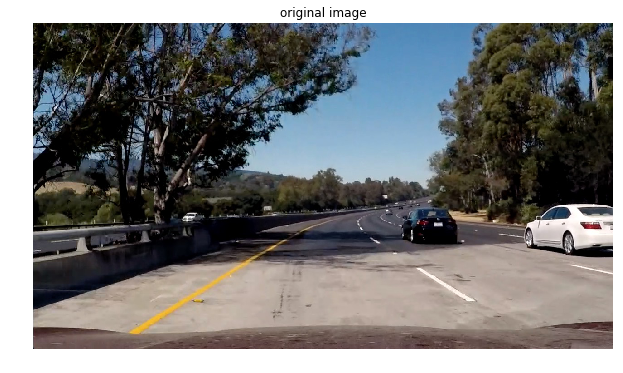

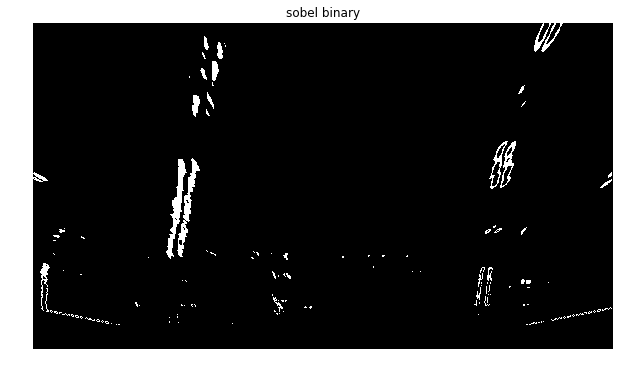

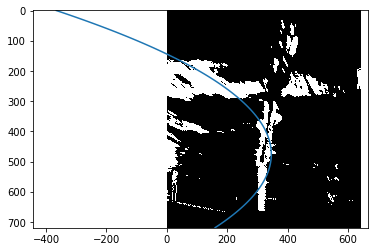

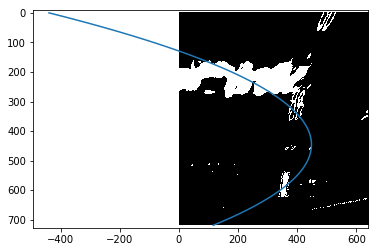

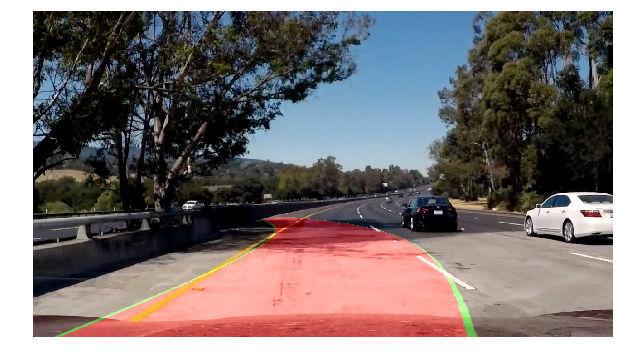

In [22]:

#img = cv2.imread('./test_images/straight_lines2.jpg')
img = cv2.imread('./test_images/test5.jpg')
plot_image(img, title='original image')

res = process_image(img)

plot_image(res)